## Homework #7

##### Author: [Radoslav Neychev](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm

### Task #1:
Let's turn to the classic problem of recognizing handwritten numbers. We will be working with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. In this task we will use the entire dataset.

__Your main task: implement the entire model training pipeline and achieve a quality of $\geq 92\%$ on the test sample.__

There is no code for training the model in this task. There are only a few tests that will help you debug your solution. For an example, you can refer to the notebook of the first lesson.

We strongly recommend writing code “from scratch”, only looking at ready-made examples, and not just “copy-pasting”. This will help you later.

Text(0.5, 1.0, 'Image label: 1')

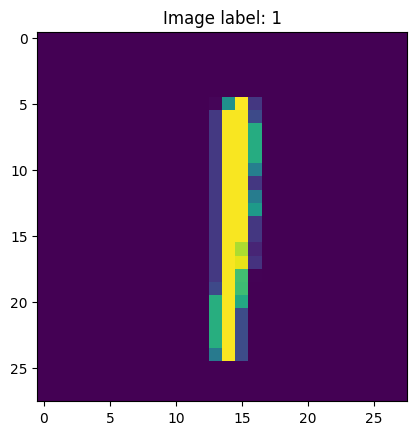

In [3]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Build the model below. Please do not build an over-complicated network; you should not make it deeper than four layers (fewer is possible). Your main task is to train the model and obtain quality on the deferred (test sample) of at least 92% accuracy.

*Comment: Linear layers and activation functions are sufficient for this.*

__Attention, your model must be represented by the `model` variable.__

In [4]:
# Creating model instance
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

Local tests to validate your model are available below:

In [5]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Tune the model parameters on the training set. We recommend working with various optimizers.

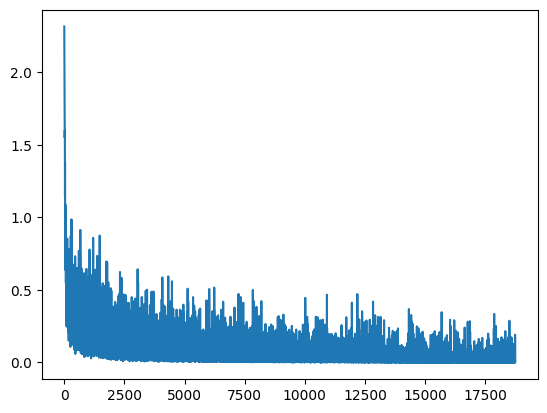

In [6]:
# your code here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []

for epoch in range(10):
    for x, y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        train_loss.append(loss_value.item())
        
    clear_output(True)
    plt.plot(train_loss)
    plt.show()

Also, we remind you that you can refer to the excellent [documentation](https://pytorch.org/docs/stable/index.html) and [training examples](https://pytorch.org/tutorials/) at any time.

Let's evaluate the quality of classification:

In [7]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [8]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99708


In [9]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [10]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9783


Checking that the required thresholds have been passed:

In [11]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Submitting the task
Download the file `hw07_data_dict.npy` (the link is on the task page) and run the code below to generate the parcel.

In [12]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_hw07.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_hw07.json`')
# __________end of block__________

File saved to `submission_dict_hw07.json`


This completes the task. Congratulations!